In [1]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer,PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from catboost import Pool, CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
data = sns.load_dataset('titanic')

In [3]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
for column in data.columns :
    print(column)
    print(data[column].value_counts(dropna=False))
    print(50*"-")

survived
0    549
1    342
Name: survived, dtype: int64
--------------------------------------------------
pclass
3    491
1    216
2    184
Name: pclass, dtype: int64
--------------------------------------------------
sex
male      577
female    314
Name: sex, dtype: int64
--------------------------------------------------
age
NaN      177
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: age, Length: 89, dtype: int64
--------------------------------------------------
sibsp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: sibsp, dtype: int64
--------------------------------------------------
parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64
--------------------------------------------------
fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.

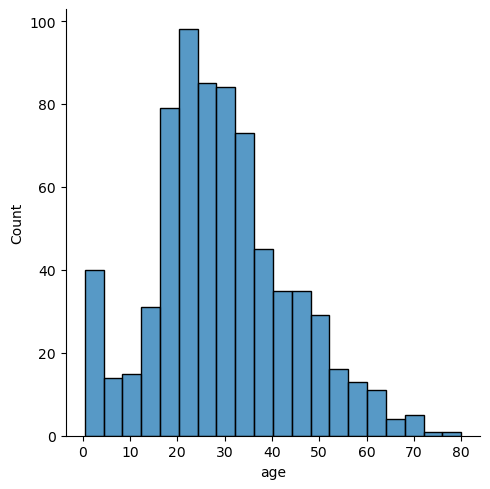

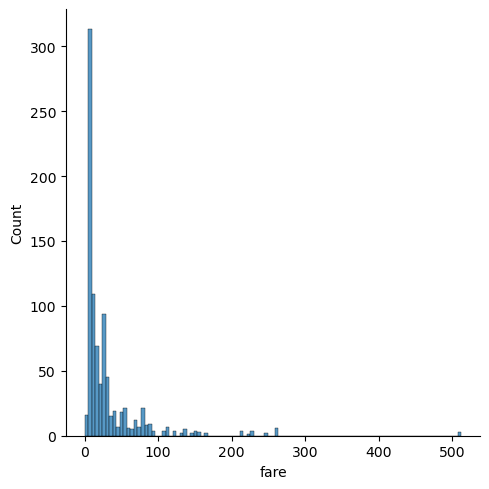

In [6]:
for column in ["age",'fare'] :
    sns.displot(data[column])

In [7]:
X= data.drop(columns=['sex','survived',"alive"])
y= data.survived

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [9]:
list_onehot = ["who",'embarked','embark_town','deck']

In [10]:
onehot_transform = make_pipeline(SimpleImputer(strategy="constant",fill_value="missing_values"),OneHotEncoder(dtype=int))

In [11]:
transformer = make_column_transformer(
    (onehot_transform, list_onehot),
    (OrdinalEncoder(categories=[['First','Second','Third']],dtype=int),["class"]),
    (make_pipeline(SimpleImputer(strategy='most_frequent'),StandardScaler()),['age']),
    (make_pipeline(SimpleImputer(),PowerTransformer()),['fare']),
    remainder='passthrough'
)

In [12]:
models = [
    CatBoostClassifier(verbose=False),
    XGBClassifier(),
    LGBMClassifier(),
    RandomForestClassifier()
]

In [13]:
for model in models :

    pipe = make_pipeline(transformer, model)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    
    print(
        "\n\033[1;97;40m - {}".format(type(model).__name__),
        (50-len(type(model).__name__))*" ",
        "\033[0m \n")
     
    print('- Train Score : \033[1;91m {:.3f}\033[0m'.format(pipe.score(X_train,y_train)))
    print('- Test Score :  \033[1;91m {:.3f}\033[0m \n'.format(pipe.score(X_test,y_test)))
    
    print(classification_report(y_test,y_pred, digits=3))
    display(pd.DataFrame(confusion_matrix(y_test,y_pred)))


 - CatBoostClassifier                                   

- Train Score :  0.922
- Test Score :   0.816 

              precision    recall  f1-score   support

           0      0.812     0.912     0.859       137
           1      0.826     0.663     0.735        86

    accuracy                          0.816       223
   macro avg      0.819     0.788     0.797       223
weighted avg      0.817     0.816     0.811       223



,0,1
0,125,12
1,29,57



 - XGBClassifier                                        

- Train Score :  0.979
- Test Score :   0.789 

              precision    recall  f1-score   support

           0      0.808     0.861     0.834       137
           1      0.753     0.674     0.712        86

    accuracy                          0.789       223
   macro avg      0.781     0.768     0.773       223
weighted avg      0.787     0.789     0.787       223



,0,1
0,118,19
1,28,58



 - LGBMClassifier                                       

- Train Score :  0.969
- Test Score :   0.780 

              precision    recall  f1-score   support

           0      0.801     0.854     0.827       137
           1      0.740     0.663     0.699        86

    accuracy                          0.780       223
   macro avg      0.771     0.758     0.763       223
weighted avg      0.778     0.780     0.778       223



,0,1
0,117,20
1,29,57



 - RandomForestClassifier                               

- Train Score :  0.985
- Test Score :   0.785 

              precision    recall  f1-score   support

           0      0.820     0.832     0.826       137
           1      0.726     0.709     0.718        86

    accuracy                          0.785       223
   macro avg      0.773     0.771     0.772       223
weighted avg      0.784     0.785     0.784       223



,0,1
0,114,23
1,25,61
